In [2]:
try:
    from abc import ABC, abstractmethod
    import sys
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.io
    from scipy.interpolate import griddata
    import time
except:
    print("One or more packages are missing...")

np.random.seed(1234)
tf.random.set_seed(1234)

print(tf.__version__)

class NeuralNetwork(ABC):
    @abstractmethod
    def initialize_NN(self, layers):
        pass

    @abstractmethod
    def neural_net(self, X, weights, biases):
        pass

    @abstractmethod
    def loss(self):
        pass

    @abstractmethod
    def train(self, nIter: int, learning_rate: float, save_model: bool):
        pass

    @abstractmethod
    def predict(self, X_star):
        pass

class PhysicsInformedNN:

    def __init__(self, x, y, t, u, v, Re, layers):

        X = np.concatenate([x, y, t], 1)

        self.lb = X.min(0)
        self.ub = X.max(0)

        self.X = X

        self.x = x
        self.y = y
        self.t = t

        self.u = u
        self.v = v

        self.Re = Re

        self.layers = layers

        # Initialize the NN
        self.weights, self.biases = self.initialize_NN(layers)

        # Create a list including all training variables
        self.train_variables = self.weights + self.biases
        # Key point: anything updates in train_variables will be
        #            automatically updated in the original tf.Variable

        # self.loss = self.loss()



    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_psi_p(self, x, y, t):
        psi_p = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        return psi_p

    def net_NS(self, x, y, t):

        psi_and_p = self.net_psi_p(x, y, t)
        # psi_and_p = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        psi = psi_and_p[:,0:1]
        p = psi_and_p[:,1:2]

        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]

        # u = self.u
        # v = self.v

        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        Re = self.Re

        # Functions describing the NS equation

        f_u = u_t + (u*u_x + v*u_y) + p_x - (1/Re)*(u_xx + u_yy)
        f_v = v_t + (u*v_x + v*v_y) + p_y - (1/Re)*(v_xx + v_yy)

        return u, v, p, f_u, f_v

    @tf.function
    # Loss function for the entire PINN
    def loss(self):
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred = \
            self.net_NS(self.x, self.y, self.t)

        loss = tf.reduce_sum(tf.square(self.u - self.u_pred)) +\
               tf.reduce_sum(tf.square(self.v - self.v_pred)) +\
               tf.reduce_sum(tf.square(self.f_u_pred)) +\
               tf.reduce_sum(tf.square(self.f_v_pred))

        return loss

    def train(self, nIter: int, learning_rate: float, save_model: bool):
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        varlist = self.weights + self.biases
        start_time = time.time()

        for it in range(nIter):
            optimizer.minimize(self.loss, varlist)

            # Print training updates
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss = self.loss().numpy()
                print('It: %d, Train Loss: %.3e, Time: %.2f' % (it, loss, elapsed))
                start_time = time.time()

        # if save_model:
        #     checkpoint = tf.train.Checkpoint(model=self)
        #     checkpoint.save("trained_model_checkpoint")

    @tf.function
    def predict(self, x_star, y_star, t_star):
        u_star, v_star, p_star, _, _ = self.net_NS(x_star, y_star, t_star)
        return u_star, v_star, p_star

2023-12-18 21:01:34.857108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [2]:
# Load and reshape data

N_train = 5000

layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]

# Load Data
data = scipy.io.loadmat("cylinder_nektar_wake.mat")

U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

In [3]:
# Training Data
idx = np.random.choice(N*T, N_train, replace=False)
x_train = tf.cast(x[idx,:], dtype=tf.float32)
y_train = tf.cast(y[idx,:], dtype=tf.float32)
t_train = tf.cast(t[idx,:], dtype=tf.float32)
u_train = tf.cast(u[idx,:], dtype=tf.float32)
v_train = tf.cast(v[idx,:], dtype=tf.float32)

2023-12-17 07:33:25.181185: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8108 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:17:00.0, compute capability: 8.0


In [4]:
model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, 100, layers)

In [5]:
model.train(200000, learning_rate=1e-3, save_model=True)

2023-12-17 07:33:37.181221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-17 07:33:38.767978: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x556cac56c3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-17 07:33:38.768009: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2023-12-17 07:33:38.772336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-17 07:33:38.790729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-12-17 07:33:38.842022: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-17 07:3

It: 0, Train Loss: 3.742e+03, Time: 8.24
It: 100, Train Loss: 6.257e+02, Time: 3.50
It: 200, Train Loss: 5.689e+02, Time: 3.50
It: 300, Train Loss: 5.401e+02, Time: 3.67
It: 400, Train Loss: 5.009e+02, Time: 3.50
It: 500, Train Loss: 4.864e+02, Time: 3.50
It: 600, Train Loss: 4.807e+02, Time: 3.48
It: 700, Train Loss: 4.779e+02, Time: 3.53
It: 800, Train Loss: 4.769e+02, Time: 3.50
It: 900, Train Loss: 4.761e+02, Time: 3.47
It: 1000, Train Loss: 4.754e+02, Time: 3.48
It: 1100, Train Loss: 4.745e+02, Time: 3.48
It: 1200, Train Loss: 4.733e+02, Time: 3.47
It: 1300, Train Loss: 4.716e+02, Time: 3.46
It: 1400, Train Loss: 4.700e+02, Time: 3.47
It: 1500, Train Loss: 4.695e+02, Time: 3.50
It: 1600, Train Loss: 4.684e+02, Time: 3.47
It: 1700, Train Loss: 4.674e+02, Time: 3.45
It: 1800, Train Loss: 4.668e+02, Time: 3.46
It: 1900, Train Loss: 4.661e+02, Time: 3.47
It: 2000, Train Loss: 4.655e+02, Time: 3.48
It: 2100, Train Loss: 4.647e+02, Time: 3.47
It: 2200, Train Loss: 4.640e+02, Time: 3.46


In [268]:
# Test Data
snap_num = 10
snap = np.array([snap_num])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]
t_star_ahead = np.tile(24, (1,N)).T

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]

x_star_new = tf.cast(x_star, dtype=tf.float32)
y_star_new = tf.cast(y_star, dtype=tf.float32)
t_star_new = tf.cast(t_star, dtype=tf.float32)
# t_star_new = tf.cast(t_star_ahead, dtype=tf.float32)

# Prediction
u_pred, v_pred, p_pred = model.predict(x_star_new, y_star_new, t_star_new)
# Error
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

In [269]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

Text(0.5, 1.0, 'Exact pressure')

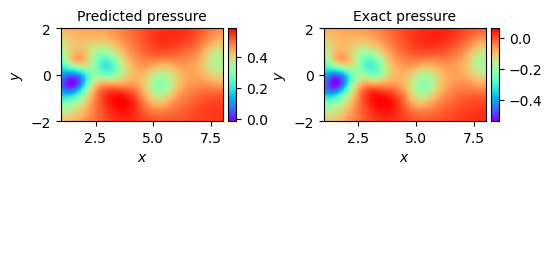

In [272]:
# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)

# UU_star = griddata(X_star, u_pred.numpy().flatten(), (X, Y), method='cubic')
# VV_star = griddata(X_star, v_pred.numpy().flatten(), (X, Y), method='cubic')
# PP_star = griddata(X_star, p_pred.numpy().flatten(), (X, Y), method='cubic')
# P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')
# UU_exact = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')

# Using loaded data
u_pred = loaded_dict['u_pred_10']
v_pred = loaded_dict['v_pred_10']
p_pred = loaded_dict['p_pred_10']

UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')
UU_exact = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')



fig, ax = newfig(1.015, 0.8)
ax.axis('off')
    
######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ########### 
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs2[:, 0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)

########     Exact p(t,x,y)     ########### 
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 10)

# savefig('./NavierStokes_prediction_100') 

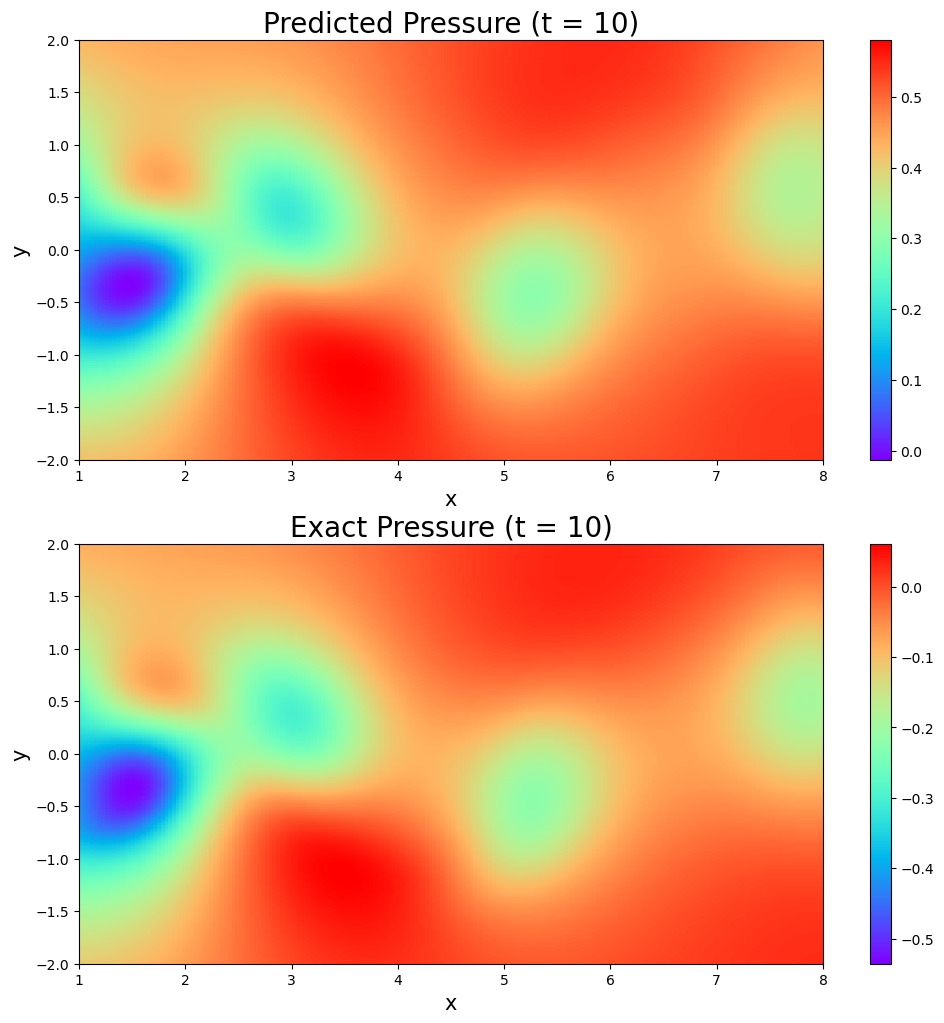

In [271]:
fig, ax = plt.subplots(2, figsize=(12,12))

ax[0].set_title('Predicted Pressure (t = %d)' %snap_num, fontsize = 20)
ax[0].set_xlabel(xlabel='x' ,size=15)
ax[0].set_ylabel(ylabel='y', size=15)
pred = ax[0].imshow(PP_star, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
fig.colorbar(pred)

ax[1].set_title('Exact Pressure (t = %d)' %snap_num, fontsize = 20)
ax[1].set_xlabel(xlabel='x' ,size=15)
ax[1].set_ylabel(ylabel='y', size=15)
real = ax[1].imshow(P_exact, interpolation='nearest', cmap='rainbow', 
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
              origin='lower', aspect='auto')
fig.colorbar(real)

savefig('NS_Pred_%d'%snap_num)

In [155]:
weights_as_np = [weight.numpy() for weight in model.weights]
biases_as_np = [bias.numpy() for bias in model.biases]

In [134]:
np.savez('model_weights', *weights_as_np)
np.savez('model_biases', *biases_as_np)

In [246]:
loaded_arrays = np.load('model_weights.npz', allow_pickle = True)
load = [np.array(loaded_arrays[file]) for file in loaded_arrays.files]

BadZipFile: Bad CRC-32 for file 'arr_0.npy'

In [256]:
#Running an array of results
predict_dict = {}
for i in range(200):
    snap_num = i
    snap = np.array([snap_num])
    x_star = X_star[:,0:1]
    y_star = X_star[:,1:2]
    t_star = TT[:,snap]
    t_star_ahead = np.tile(24, (1,N)).T

    u_star = U_star[:,0,snap]
    v_star = U_star[:,1,snap]
    p_star = P_star[:,snap]

    x_star_new = tf.cast(x_star, dtype=tf.float32)
    y_star_new = tf.cast(y_star, dtype=tf.float32)
    t_star_new = tf.cast(t_star, dtype=tf.float32)
    # t_star_new = tf.cast(t_star_ahead, dtype=tf.float32)

    # Prediction
    u_pred, v_pred, p_pred = model.predict(x_star_new, y_star_new, t_star_new)
    predict_dict['u_pred_%d' %i] = u_pred.numpy()
    predict_dict['v_pred_%d' %i] = v_pred.numpy()
    predict_dict['p_pred_%d' %i] = p_pred.numpy()

In [261]:
np.savez('predictions_dictionary.npz', **predict_dict)

In [4]:
loaded_dict = np.load('data/predictions_dictionary.npz')

In [12]:
loaded_dict

['u_pred_0',
 'v_pred_0',
 'p_pred_0',
 'u_pred_1',
 'v_pred_1',
 'p_pred_1',
 'u_pred_2',
 'v_pred_2',
 'p_pred_2',
 'u_pred_3',
 'v_pred_3',
 'p_pred_3',
 'u_pred_4',
 'v_pred_4',
 'p_pred_4',
 'u_pred_5',
 'v_pred_5',
 'p_pred_5',
 'u_pred_6',
 'v_pred_6',
 'p_pred_6',
 'u_pred_7',
 'v_pred_7',
 'p_pred_7',
 'u_pred_8',
 'v_pred_8',
 'p_pred_8',
 'u_pred_9',
 'v_pred_9',
 'p_pred_9',
 'u_pred_10',
 'v_pred_10',
 'p_pred_10',
 'u_pred_11',
 'v_pred_11',
 'p_pred_11',
 'u_pred_12',
 'v_pred_12',
 'p_pred_12',
 'u_pred_13',
 'v_pred_13',
 'p_pred_13',
 'u_pred_14',
 'v_pred_14',
 'p_pred_14',
 'u_pred_15',
 'v_pred_15',
 'p_pred_15',
 'u_pred_16',
 'v_pred_16',
 'p_pred_16',
 'u_pred_17',
 'v_pred_17',
 'p_pred_17',
 'u_pred_18',
 'v_pred_18',
 'p_pred_18',
 'u_pred_19',
 'v_pred_19',
 'p_pred_19',
 'u_pred_20',
 'v_pred_20',
 'p_pred_20',
 'u_pred_21',
 'v_pred_21',
 'p_pred_21',
 'u_pred_22',
 'v_pred_22',
 'p_pred_22',
 'u_pred_23',
 'v_pred_23',
 'p_pred_23',
 'u_pred_24',
 'v_pred

In [1]:
import numpy as np

In [3]:
np.load('/Users/fairuzishraque/Downloads/PINN Results/PINN Test Model Weights/arr_1.npy')

array([[ 6.30262256e-01,  1.00001678e-01, -2.52374522e-02,
        -4.43461508e-01,  1.89259753e-01,  3.00009817e-01,
        -1.54924259e-01, -2.65397966e-01,  1.97334245e-01,
        -5.16755223e-01,  3.84153873e-01, -3.50512534e-01,
         4.34074253e-01, -3.22083235e-02, -1.09985903e-01,
         3.57764721e-01, -5.58473587e-01,  5.11737704e-01,
         4.75448698e-01,  2.03210235e-01],
       [ 1.89672008e-01,  4.30110157e-01,  3.71131629e-01,
        -4.65340763e-01, -4.25255656e-01, -6.25438571e-01,
         8.91008079e-02, -4.19515133e-01,  1.42923877e-01,
        -3.42252672e-01, -1.36428699e-01,  3.61819804e-01,
         2.02291697e-01,  3.85419577e-01,  1.20108992e-01,
        -2.18039826e-02, -1.38373628e-01,  6.76964447e-02,
        -3.71730491e-03, -4.07791853e-01],
       [-1.56085670e-01,  1.14587419e-01, -3.21097523e-01,
        -2.61872113e-01,  4.06141490e-01,  2.54154831e-01,
         6.59548283e-01,  2.86034867e-02, -5.19927638e-03,
         6.98664129e-01, -2.3